### Fraud Detection - Model Training and Evaluation
Includes:
- Logistic Regression (Baseline)
- Random Forest with GridSearchCV
- XGBoost with GridSearchCV
- Evaluation and PR Curve Comparison
- Model Selection and Justification
- Best Model Export

In [11]:
# !pip install xgboost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve, auc
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

#### Load Preprocessed Data

In [2]:
X_train_bal = joblib.load("../outputs/X_train_bal.pkl")
y_train_bal = joblib.load("../outputs/y_train_bal.pkl")
X_test = joblib.load("../outputs/X_test.pkl")
y_test = joblib.load("../outputs/y_test.pkl")
scaler = joblib.load("../outputs/scaler.pkl")
X_test_scaled = scaler.transform(X_test)

#### Logistic Regression

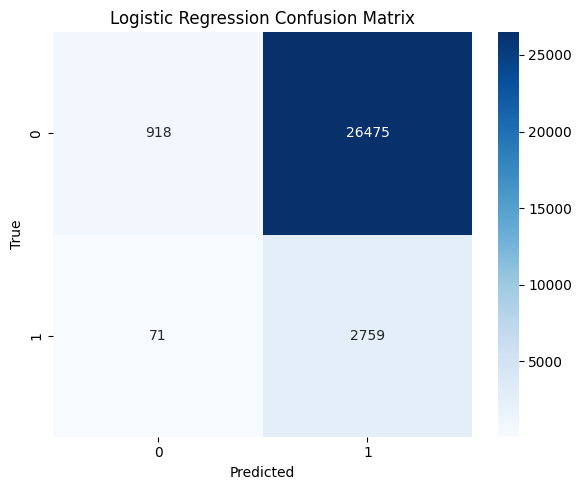

In [3]:
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_bal, y_train_bal)
y_pred_logreg = logreg.predict(X_test_scaled)
y_pred_proba_logreg = logreg.predict_proba(X_test_scaled)[:, 1]
auc_pr_logreg = average_precision_score(y_test, y_pred_proba_logreg)

# Save model
joblib.dump(logreg, "../outputs/models/logistic_regression.pkl")

# Confusion Matrix
conf_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_logreg, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
plt.savefig("../outputs/figures/logistic_regression_confusion_matrix.png")
plt.close()

#### Random Forest

Fitting 3 folds for each of 1 candidates, totalling 3 fits


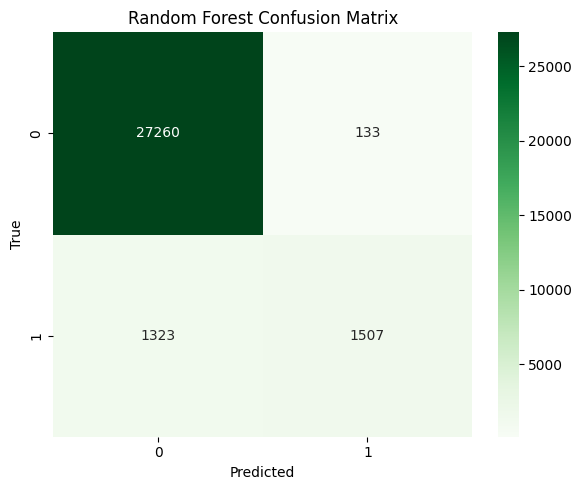

In [4]:
rf_param_grid = {
    'n_estimators': [100],
    'max_depth': [None],
    'min_samples_split': [2],
    'class_weight': ['balanced']
}
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search_rf = GridSearchCV(rf, rf_param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train_bal, y_train_bal)
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]
auc_pr_rf = average_precision_score(y_test, y_pred_proba_rf)

# Save model
joblib.dump(best_rf, "../outputs/models/random_forest.pkl"),

# Confusion Matrix
conf_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_rf, annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
plt.savefig("../outputs/figures/random_forest_confusion_matrix.png")
plt.close()

#### XGBoost

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/milky/Documents/10 Academy/fraud-detection-kaim-week8-9/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:27:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/milky/Documents/10 Academy/fraud-detection-kaim-week8-9/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:27:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/milky/Documents/10 Academy/fraud-detection-kaim-week8-9/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:27:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


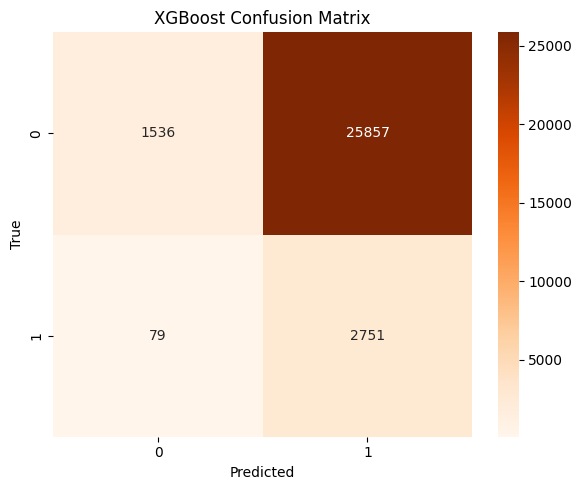

In [5]:
xgb_param_grid = {
    'n_estimators': [100],
    'max_depth': [3],
    'learning_rate': [0.1],
    'scale_pos_weight': [9.7]
}
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search_xgb = GridSearchCV(xgb, xgb_param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train_bal, y_train_bal)
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
y_pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]
auc_pr_xgb = average_precision_score(y_test, y_pred_proba_xgb)

# Save model
joblib.dump(best_xgb, "../outputs/models/xgboost.pkl")

# Confusion Matrix
conf_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_xgb, annot=True, fmt='d', cmap='Oranges')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
plt.savefig("../outputs/figures/xgboost_confusion_matrix.png")
plt.close()

#### PR Curve Comparison

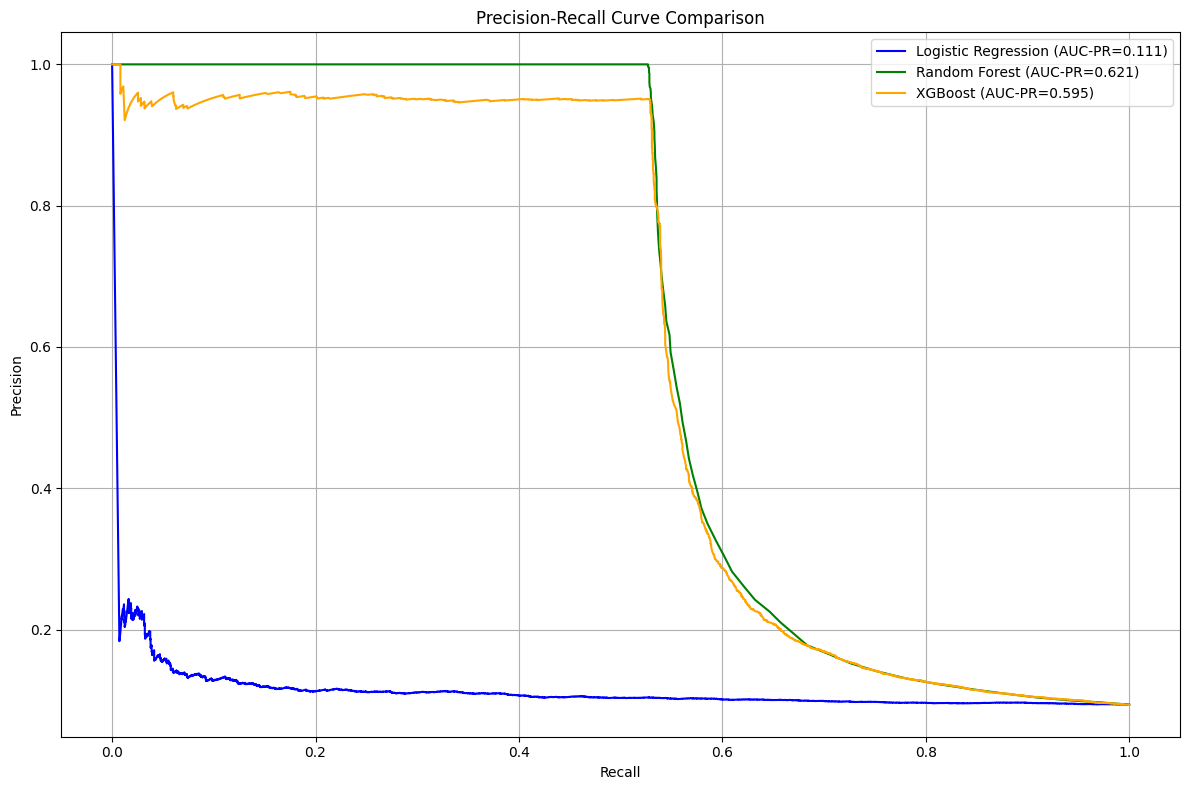

In [6]:
plt.figure(figsize=(12, 8))
for name, y_score, color in zip(
    ['Logistic Regression', 'Random Forest', 'XGBoost'],
    [y_pred_proba_logreg, y_pred_proba_rf, y_pred_proba_xgb],
    ['blue', 'green', 'orange']
):
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    ap = average_precision_score(y_test, y_score)
    plt.plot(recall, precision, label=f"{name} (AUC-PR={ap:.3f})", color=color)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../outputs/figures/pr_curve_comparison.png")
plt.show()

#### Performance Comparison

In [7]:
f1_scores = {
    'Logistic Regression': classification_report(y_test, y_pred_logreg, output_dict=True)['1']['f1-score'],
    'Random Forest': classification_report(y_test, y_pred_rf, output_dict=True)['1']['f1-score'],
    'XGBoost': classification_report(y_test, y_pred_xgb, output_dict=True)['1']['f1-score']
}
auc_pr_scores = {
    'Logistic Regression': auc_pr_logreg,
    'Random Forest': auc_pr_rf,
    'XGBoost': auc_pr_xgb
}

print("\n=== Model Performance Comparison ===")
print("F1 Scores:")
for model, f1 in f1_scores.items():
    print(f"{model}: {f1:.3f}")

print("\nAUC-PR Scores:")
for model, aucpr in auc_pr_scores.items():
    print(f"{model}: {aucpr:.3f}")

best_model_f1 = max(f1_scores, key=f1_scores.get)
best_model_aucpr = max(auc_pr_scores, key=auc_pr_scores.get)

print(f"\n Best Model by F1 Score: {best_model_f1}")
print(f" Best Model by AUC-PR: {best_model_aucpr}")


=== Model Performance Comparison ===
F1 Scores:
Logistic Regression: 0.172
Random Forest: 0.674
XGBoost: 0.175

AUC-PR Scores:
Logistic Regression: 0.111
Random Forest: 0.621
XGBoost: 0.595

 Best Model by F1 Score: Random Forest
 Best Model by AUC-PR: Random Forest


In [8]:
# Export Metrics to CSV and JSON
metrics_df = pd.DataFrame({
    'Model': list(f1_scores.keys()),
    'F1_Score': list(f1_scores.values()),
    'AUC_PR': list(auc_pr_scores.values())
})
metrics_df.to_csv("../outputs/metrics/model_performance_comparison.csv", index=False)
print("\n Model performance metrics saved to outputs/metrics/model_performance_comparison.csv")

# Save to JSON
import json
metrics_dict = metrics_df.set_index('Model').to_dict(orient='index')
with open("../outputs/metrics/model_performance_comparison.json", "w") as f:
    json.dump(metrics_dict, f, indent=4)
print(" Model performance metrics saved to outputs/metrics/model_performance_comparison.json")


 Model performance metrics saved to outputs/metrics/model_performance_comparison.csv
 Model performance metrics saved to outputs/metrics/model_performance_comparison.json
